<a href="https://colab.research.google.com/github/sweet6th8/image-captioning/blob/main/image-captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study: SEMINAR IMAGE CAPTIONING
---

**Thành viên:**
- 22130132 Bùi Quang Tấn Kiệt
- 22130140 Nguyễn Thị Lang

**Ngày hoàn thành:** 22/05/2025

**Môn học:** Machine Learning

**Trường:** Đại Học Nông Lâm TP.HCM - Khoa CNNT


# Introduction
- Mô hình được xây dựng dựa trên kiến trúc **CNN + RNN(LSTM)**, được đề xuất trong bài báo **"Show and Tell: A Neural Image Caption Generator"** của Google [1]. Trong đó, CNN được sử dụng để trích xuất đặc trưng hình ảnh, còn LSTM đảm nhiệm vai trò sinh mô tả cho hình ảnh.
- Dữ liệu huấn luyện được lấy từ bộ dataset **Flickr8k** trên Kaggle. Bộ dataset **Flickr8k** gồm hơn 8k bức ảnh, mỗi ảnh đi kèm với 5 mô tả ngắn (caption).
- Để đánh giá mô hình, chúng tôi chủ yếu sử dụng 4 metrics:
  - BLEU-1
  - BLEU-4
  - METEOR
  - CIDEr
- Kết quả đạt được trên tập Flickr8k:

```
| BLEU-1 | BLEU-4 | METEOR | CIDEr |
|--------|--------|--------|-------|
| 0.5296 | 0.1287 | 0.2985 | 0.4735|
```

# Resource
Các model, đặc trưng ảnh, tokenizer và kết quả dự đoán được lưu trong thư mục Drive sau:
[Link thư mục Drive](https://drive.google.com/drive/folders/18_l_1G6h4fPO3pD4p8ydifSPab88YOsu?usp=sharing)

---

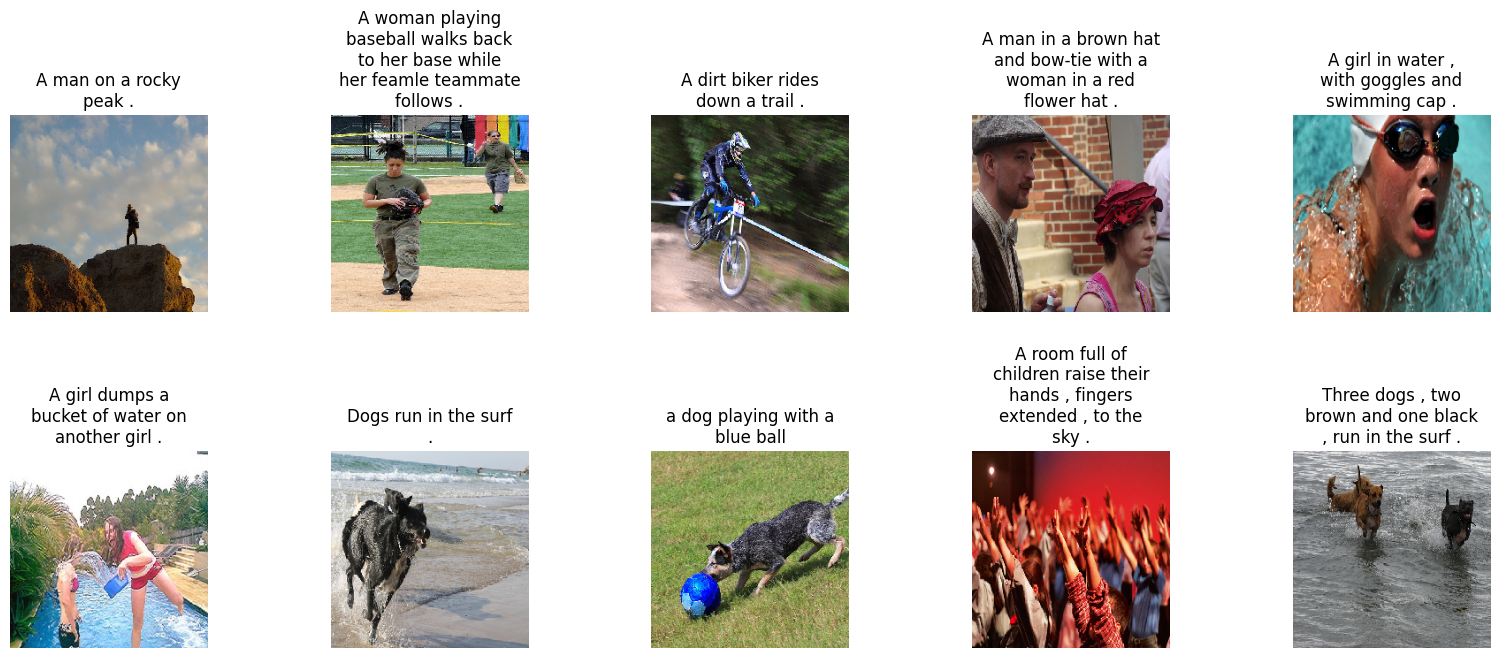

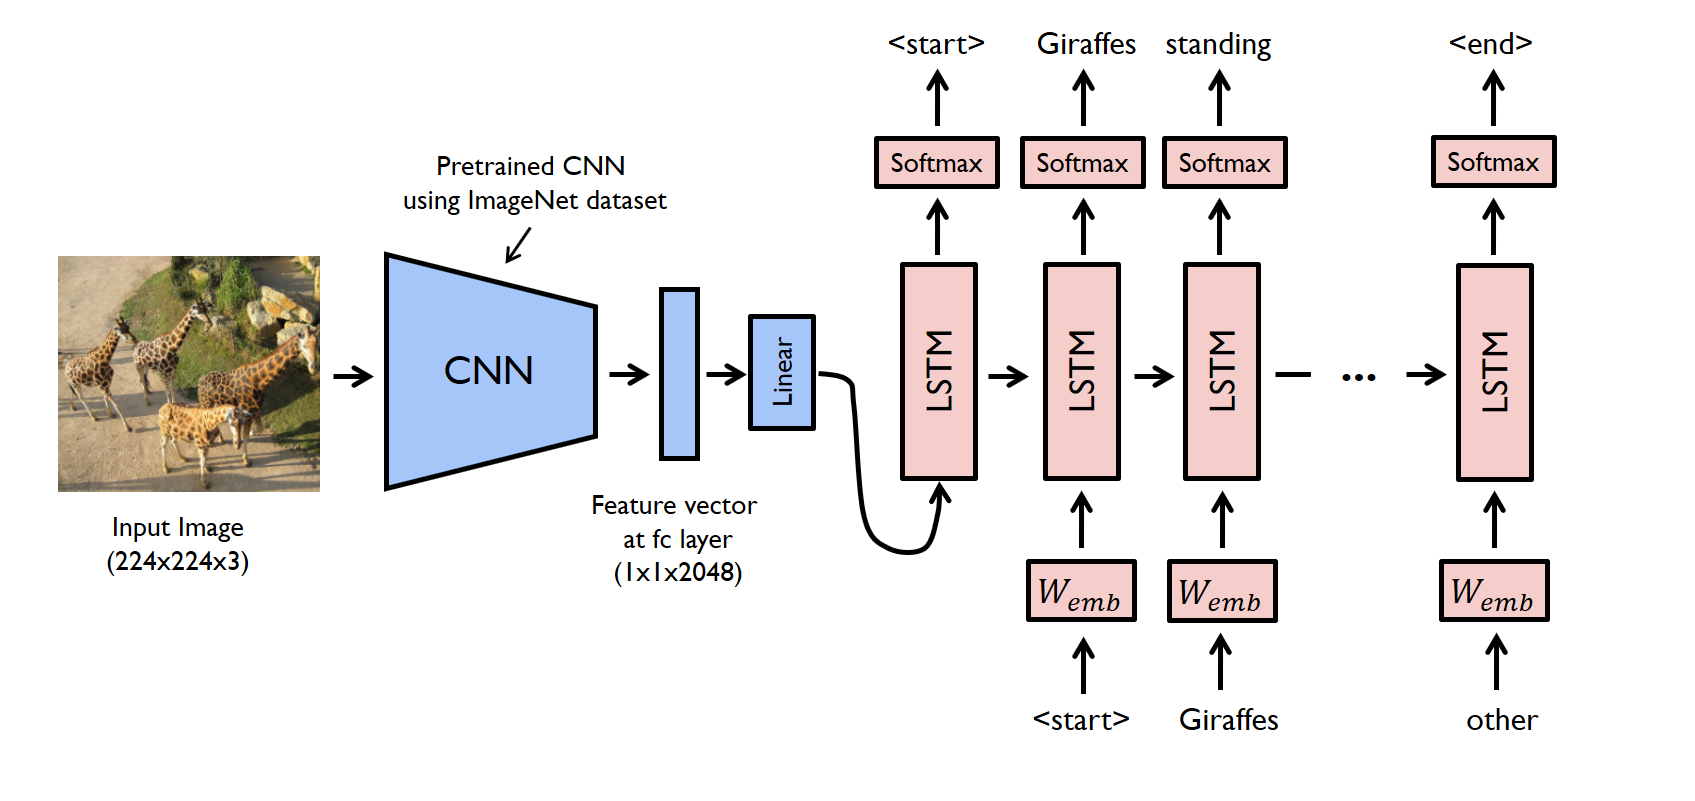

---

# Import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Embedding, Add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import pickle

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load dataset


In [ ]:
import kagglehub

path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [ ]:
IMAGE_PATH = os.path.join(path, 'Images')
CAPTION_PATH = os.path.join(path, 'captions.txt')

In [ ]:
df = pd.read_csv(CAPTION_PATH)
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

# Visualize

In [ ]:
# đọc hình ảnh
def readImageRBG(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img

# xem hình ảnh preview
def previewImage(image_name):
  img = readImageRBG(os.path.join(IMAGE_PATH, image_name))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

# xem các caption của hình ảnh (mỗi ảnh 5 caption)
def previewCaption(image_name):
  print(f"Caption cho ảnh {image_name}:")
  captions = df[df['image'] == image_name]['caption'].tolist()
  for caption in captions: print('-', caption)

# preview ảnh và caption
def previewImageCaption(image_name, captions=None):
  img = readImageRBG(os.path.join(IMAGE_PATH, image_name))

  plt.figure(figsize=(6,6))
  plt.imshow(img)
  plt.axis('off')

  if captions is None:
    captions = df[df['image'] == image_name]['caption'].tolist()
  full_caption = '\n'.join(f"{cap}" for cap in captions)
  plt.title(full_caption, fontsize=10, loc='left', pad=10)

  plt.show()

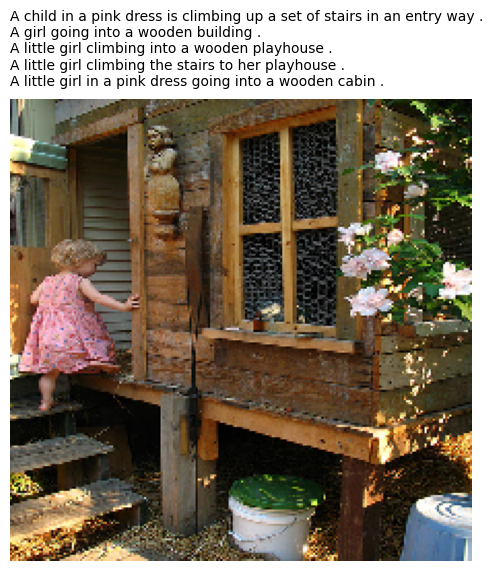

In [ ]:
previewImageCaption('1000268201_693b08cb0e.jpg')

# Preprocessing


### Image preprocessing

In [ ]:
# đọc hình ảnh và process theo input của vgg16
def readImage(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = preprocess_input(img)
    return img

# trích xuất đặc trưng từ hình ảnh
def extractFeature(image, model):
    img = np.expand_dims(image, axis=0)
    feature = model.predict(img)
    return feature

# Tạo dataset từ danh sách đường dẫn ảnh
def createImageDataset(image_paths, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = path_ds.map(readImage, num_parallel_calls=tf.data.AUTOTUNE)
    image_ds = image_ds.batch(batch_size)
    image_ds = image_ds.prefetch(tf.data.AUTOTUNE)

    return image_ds

In [ ]:
# model vgg16 (cnn)
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# tạo encoder (bỏ layer output của vgg16)
encoder = Model(inputs=vgg16.input, outputs=vgg16.layers[-2].output)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# tạo list đường dẫn tới các ảnh
image_names = df['image'].unique().tolist()
image_paths = [f'{IMAGE_PATH}/{img}' for img in image_names]
print(len(image_paths))
print(image_paths[0])
# tạo dataset images theo từng batch
image_ds = createImageDataset(image_paths, batch_size=32)

8091
/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg


In [ ]:
features = encoder.predict(image_ds)
features.shape

253/253 ━━━━━━━━━━━━━━━━━━━━ 85s 285ms/step


(8091, 4096)

In [ ]:
np.save("/content/features.npy", features)

### Text preprocessing

In [ ]:
def text_preprocess(text):
    # lowercase
    text = text.lower()
    # chỉ giữ chữ cái và khoảng trắng
    text = re.sub(r'[^a-z\s]', '', text)
    # loại bỏ các từ 1 chữ cái
    text = ' '.join([word for word in text.split() if len(word) > 1])
    # loại bỏ khoảng trắng dư thừa
    text = re.sub(r'\s+', ' ', text).strip()
    # startseq + caption + endseq
    text = f'startseq {text} endseq'

    return text

In [ ]:
captions = [text_preprocess(cap) for cap in df['caption'].to_list()]

In [ ]:
df['sequence']=captions
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going into a wooden building .   
2   A little girl climbing into a wooden playhouse .   
3  A little girl climbing the stairs to her playh...   
4  A little girl in a pink dress going into a woo...   

                                            sequence  
0  startseq child in pink dress is climbing up se...  
1    startseq girl going into wooden building endseq  
2  startseq little girl climbing into wooden play...  
3  startseq little girl climbing the stairs to he...  
4  startseq little girl in pink dress going into ...

In [ ]:
# Tokenization
def tokenization(captions, num_words=10000):
  # giới hạn độ dài tối đa của mỗi câu
  max_length = max(len(cap.split()) for cap in captions)

  # tạo tokenizer
  tokenizer = Tokenizer(num_words=num_words, oov_token='<unk>')
  tokenizer.fit_on_texts(captions)

  # report
  print('max_length:', max_length)
  print('vocab_size:', len(tokenizer.word_index)+1)
  print("word_index:", tokenizer.word_index)
  print("word_counts:", tokenizer.word_counts)

  return tokenizer, max_length

In [ ]:
tokenizer, max_length = tokenization(captions)

max_length: 34
vocab_size: 8769
word_index: {'<unk>': 1, 'startseq': 2, 'endseq': 3, 'in': 4, 'the': 5, 'on': 6, 'is': 7, 'and': 8, 'dog': 9, 'with': 10, 'man': 11, 'of': 12, 'two': 13, 'white': 14, 'black': 15, 'boy': 16, 'are': 17, 'woman': 18, 'girl': 19, 'to': 20, 'wearing': 21, 'at': 22, 'people': 23, 'water': 24, 'red': 25, 'young': 26, 'brown': 27, 'an': 28, 'his': 29, 'blue': 30, 'dogs': 31, 'running': 32, 'through': 33, 'playing': 34, 'while': 35, 'down': 36, 'shirt': 37, 'standing': 38, 'ball': 39, 'little': 40, 'grass': 41, 'child': 42, 'person': 43, 'snow': 44, 'jumping': 45, 'over': 46, 'front': 47, 'three': 48, 'sitting': 49, 'holding': 50, 'field': 51, 'small': 52, 'up': 53, 'by': 54, 'large': 55, 'green': 56, 'group': 57, 'one': 58, 'yellow': 59, 'her': 60, 'walking': 61, 'children': 62, 'men': 63, 'into': 64, 'air': 65, 'beach': 66, 'near': 67, 'mouth': 68, 'jumps': 69, 'another': 70, 'for': 71, 'street': 72, 'runs': 73, 'its': 74, 'from': 75, 'riding': 76, 'stands': 7

In [ ]:
# Xem trước và sau khi xử lý
i = 0
print(df['caption'][i])
print(captions[i])
print(tokenizer.texts_to_sequences([captions[i]]))

A child in a pink dress is climbing up a set of stairs in an entry way .
startseq child in pink dress is climbing up set of stairs in an entry way endseq
[[2, 42, 4, 90, 169, 7, 119, 53, 394, 12, 391, 4, 28, 5193, 692, 3]]


# Data Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features_dict, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features_dict = features_dict
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features_dict[image]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                    # out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

# Train, Test split

In [ ]:
images = df['image'].unique().tolist()

feature_dict = {}
#features = np.load("/content/features.npy")

for image, feature in zip(images, features):
  feature_dict[image] = feature

print(len(feature_dict))

8091


In [ ]:
img_train, img_test = train_test_split(images, test_size=0.2, random_state=42)
X_train = df[df['image'].isin(img_train)]
X_test = df[df['image'].isin(img_test)]
print(len(img_train))
print(len(img_test))
print(X_train.shape)
print(X_test.shape)

6472
1619
(32360, 3)
(8095, 3)


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

train_generator = DataGenerator(
    df=X_train, X_col='image', y_col='sequence',
    batch_size=64, directory=IMAGE_PATH,
    tokenizer=tokenizer, vocab_size=vocab_size,
    max_length=max_length, features_dict=feature_dict)

validation_generator = DataGenerator(
    df=X_test, X_col='image', y_col='sequence',
    batch_size=64, directory=IMAGE_PATH,
    tokenizer=tokenizer, vocab_size=vocab_size,
    max_length=max_length,features_dict=feature_dict)


8769


# Modeling


## Model

In [ ]:
# Define the model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

# Create the model
model = define_model(vocab_size, max_length)

# plot model
# plot_model(model, show_shapes=True, show_layer_names=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,244,864 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8769)      │  2,253,633 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,138,433 (23.42 MB)

 Trainable params: 6,138,433 (23.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

## Train

In [ ]:
# Train the model
history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.9018
Epoch 1: val_loss improved from inf to 3.81626, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - loss: 3.9015 - val_loss: 3.8163 - learning_rate: 0.0010
Epoch 2/10
156/505 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 3.3771

KeyboardInterrupt: 

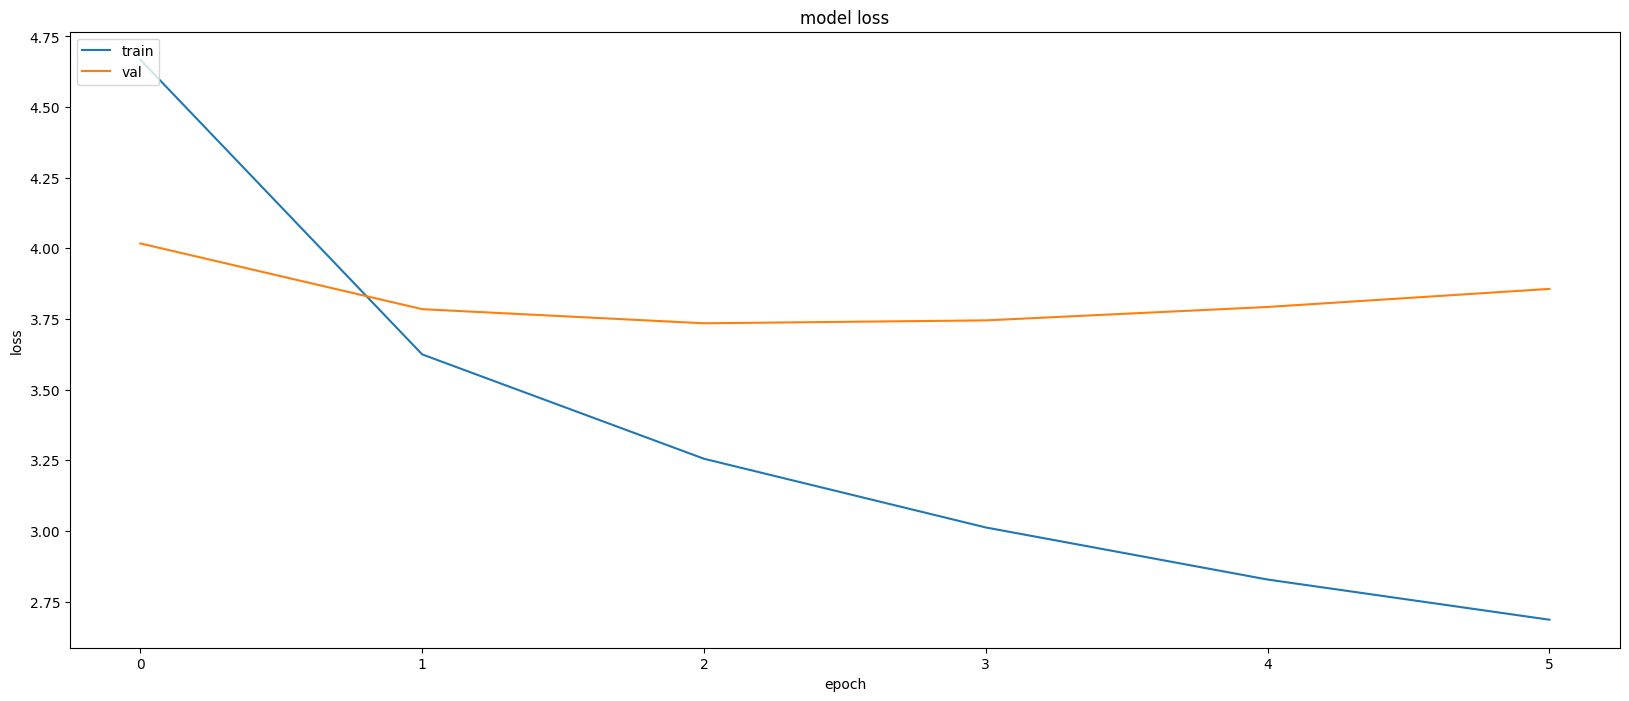

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_fe            │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_se            │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_1 (Dropout) │ (None, 4096)      │          0 │ input_fe[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,244,864 │ input_se[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 34)        │          0 │ input_se[0][0]    │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_2 (Dense)   │ (None, 256)       │  1,048,832 │ feature_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ embedding[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_1 (Add)     │ (None, 256)       │          0 │ feature_2[0][0],  │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_2 (Dense)   │ (None, 256)       │     65,792 │ decoder_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 8769)      │  2,253,633 │ decoder_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,138,433 (23.42 MB)

 Trainable params: 6,138,433 (23.42 MB)

 Non-trainable params: 0 (0.00 B)

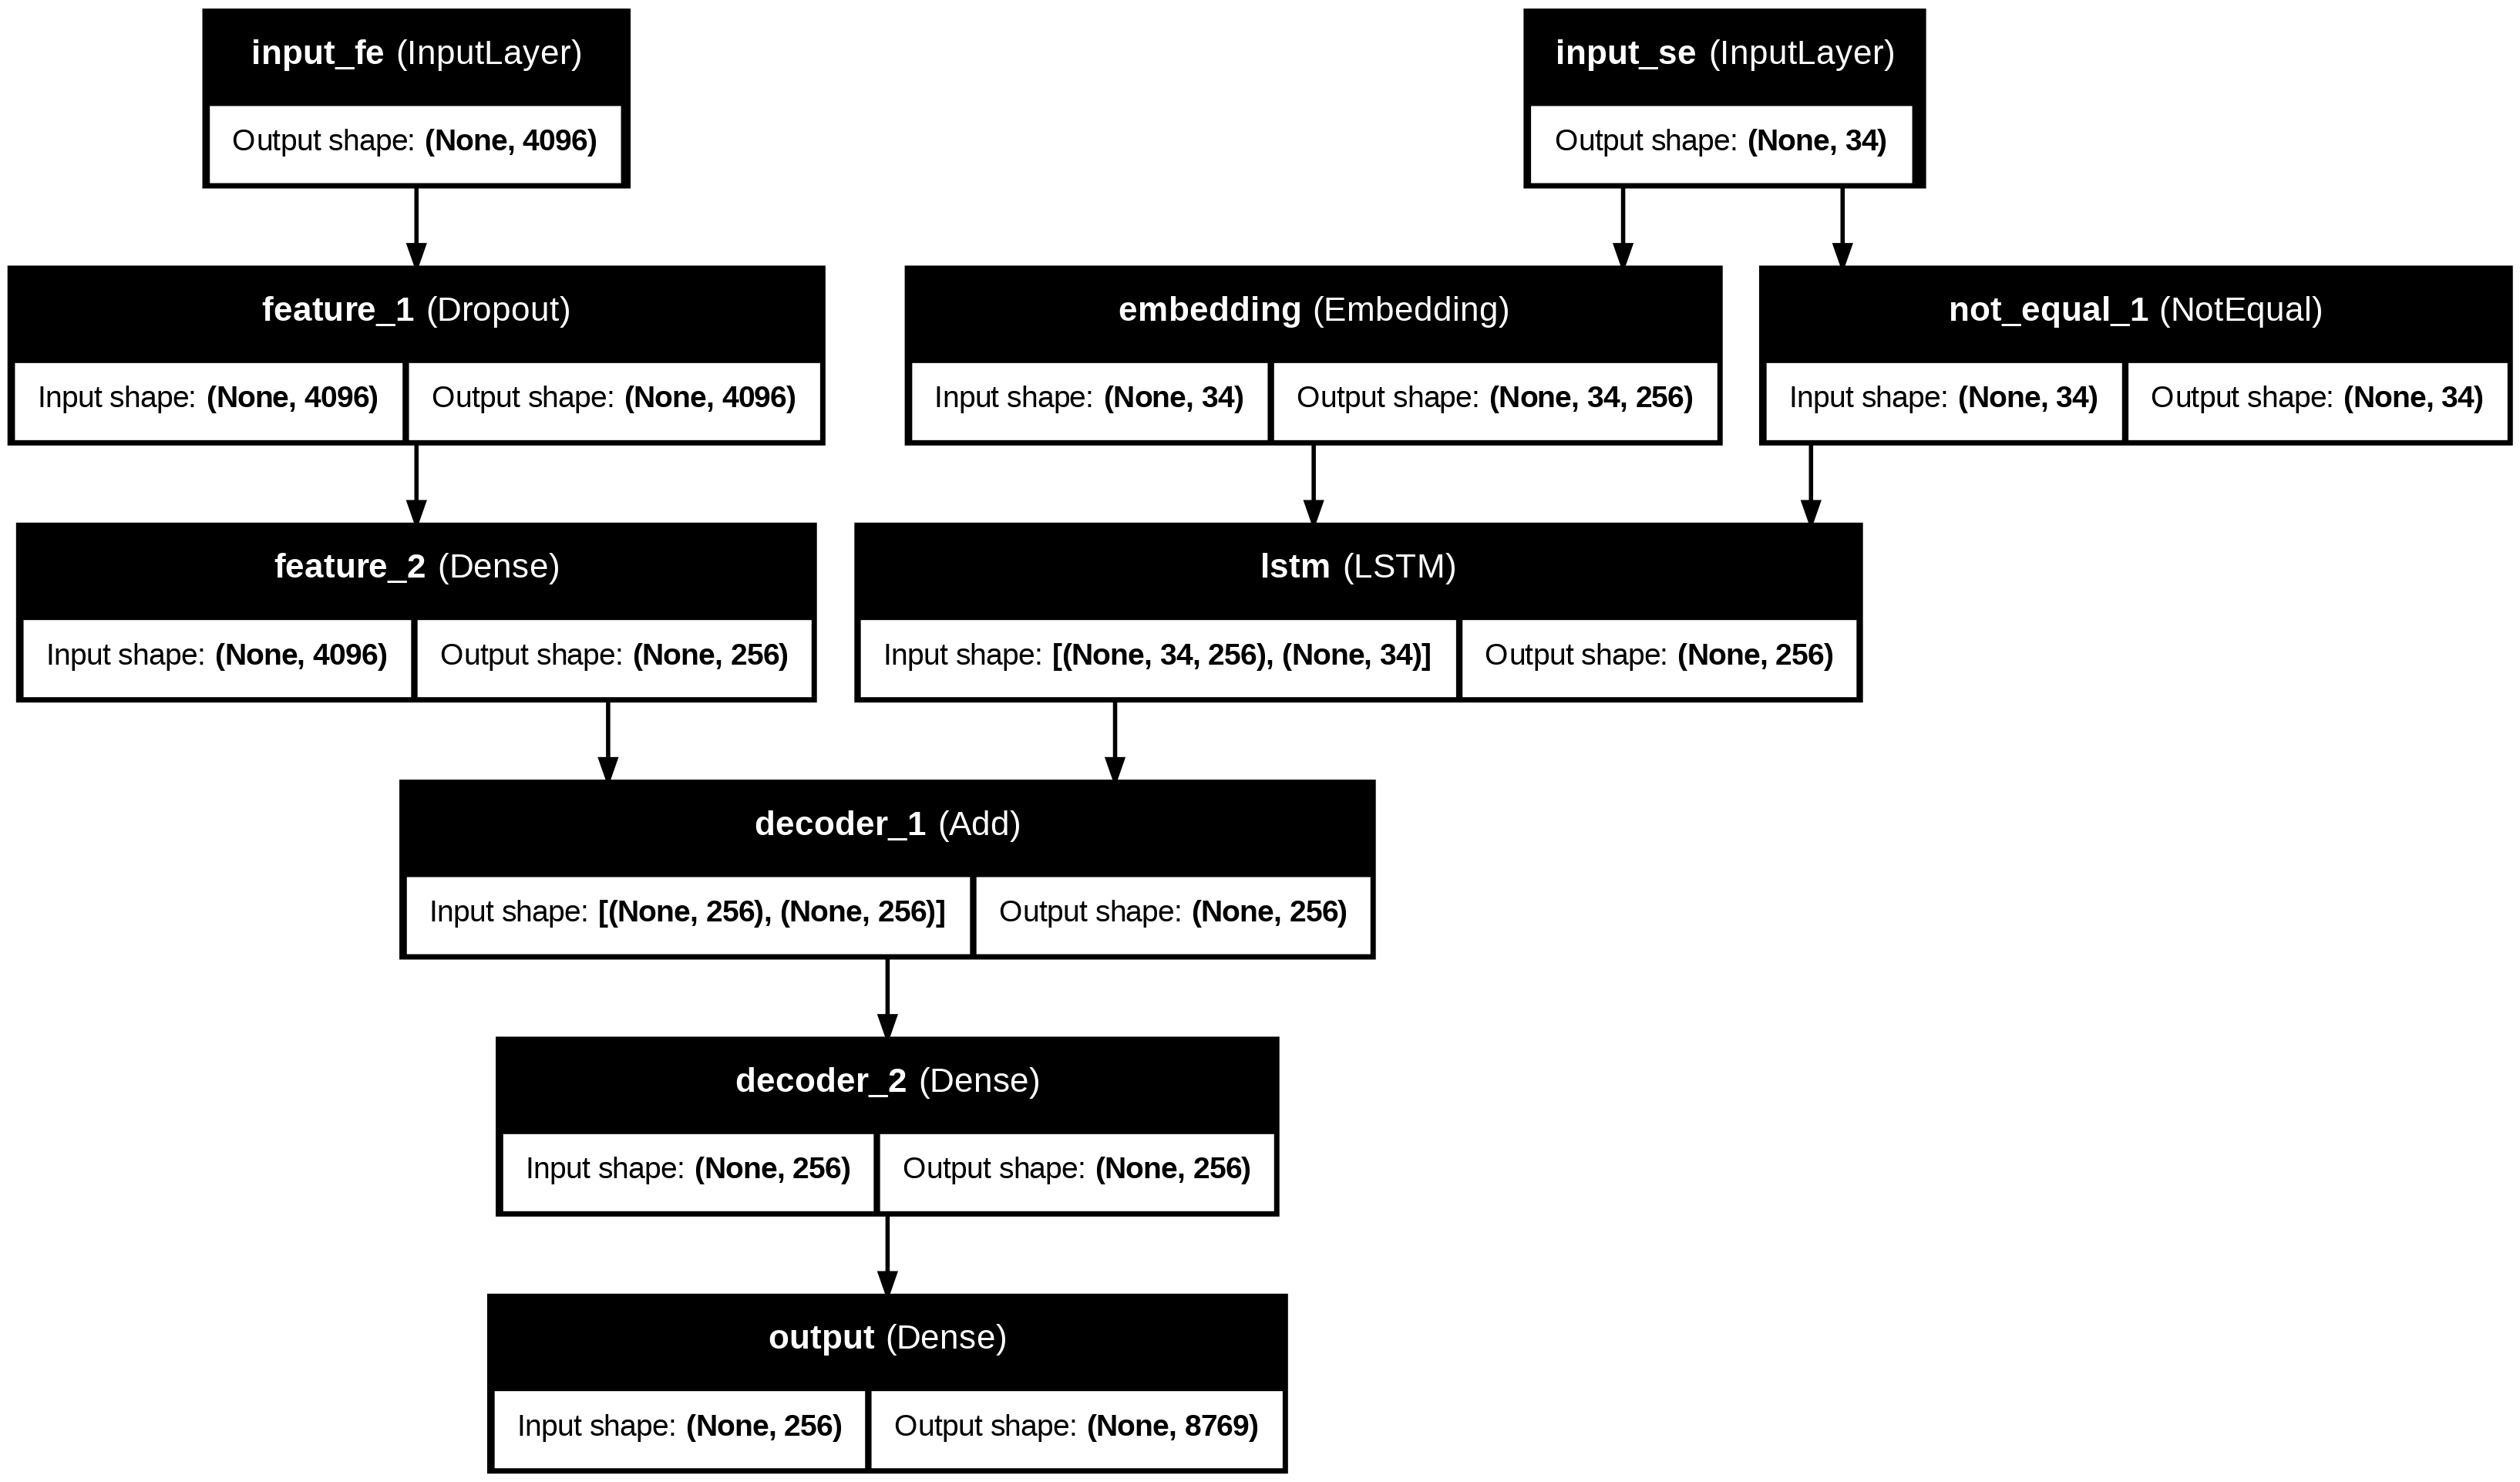

In [ ]:
# encoder feature
input_feature = Input(shape=(4096,), name='input_fe')
fe1 = Dropout(0.5, name='feature_1')(input_feature)
fe2 = Dense(256, activation='relu', name='feature_2')(fe1)
# encoder sequence
input_sequence = Input(shape=(max_length,), name='input_se')
se1 = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True, name='embedding')(input_sequence)
se2 = LSTM(256, name='lstm')(se1)
# decoder (feature+sequence)
decoder1 = Add(name='decoder_1')([fe2, se2])
decoder2 = Dense(256, activation='relu', name='decoder_2')(decoder1)
output = Dense(vocab_size, activation='softmax', name='output')(decoder2)

model = Model(inputs=[input_feature, input_sequence], outputs=output)

# visualize model
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
)

In [ ]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

## Train

In [ ]:
# Train the model
history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 5.2967
Epoch 1: val_loss improved from inf to 3.96504, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 81s 72ms/step - loss: 5.2953 - val_loss: 3.9650 - learning_rate: 0.0010
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.6233
Epoch 2: val_loss improved from 3.96504 to 3.72723, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - loss: 3.6232 - val_loss: 3.7272 - learning_rate: 0.0010
Epoch 3/10
504/505 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 3.1902
Epoch 3: val_loss improved from 3.72723 to 3.69346, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 3.1902 - val_loss: 3.6935 - learning_rate: 0.0010
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.9079
Epoch 4: val_loss did not improve from 3.69346
505/505 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - loss: 2.9079 - val_loss: 3.7242 - learning_rate: 0.0010
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0

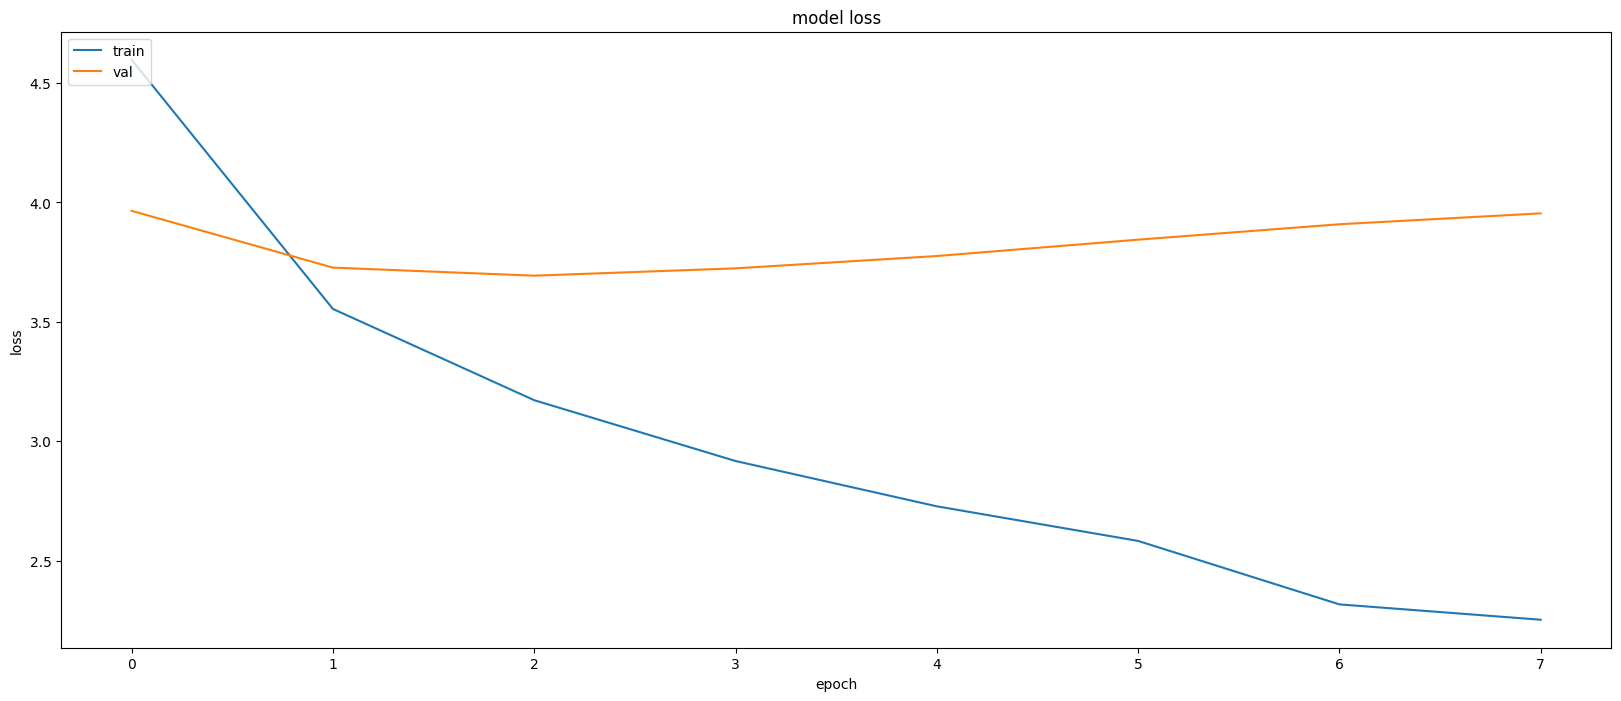

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Prediction

In [ ]:
def predict_caption(model, tokenizer, max_length, feature_vector):
    # Bắt đầu với từ 'startseq' để tạo caption
    in_text = 'startseq'

    # Tiến hành dự đoán từng từ cho đến khi gặp 'endseq'
    for _ in range(max_length):
        # Chuyển chuỗi input thành một danh sách các token
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # Padding để đảm bảo chuỗi có độ dài max_length
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Dự đoán từ tiếp theo
        yhat = model.predict([np.expand_dims(feature_vector, axis=0), sequence], verbose=0)

        # Chuyển output từ mô hình (xác suất) thành chỉ số của từ có xác suất cao nhất
        yhat = np.argmax(yhat)

        # Chuyển chỉ số của từ thành từ tương ứng trong từ điển
        word = tokenizer.index_word.get(yhat, '')

        in_text += ' ' + word

        # Nếu gặp token kết thúc endseq thì đừng
        if word == 'endseq': break

    return in_text


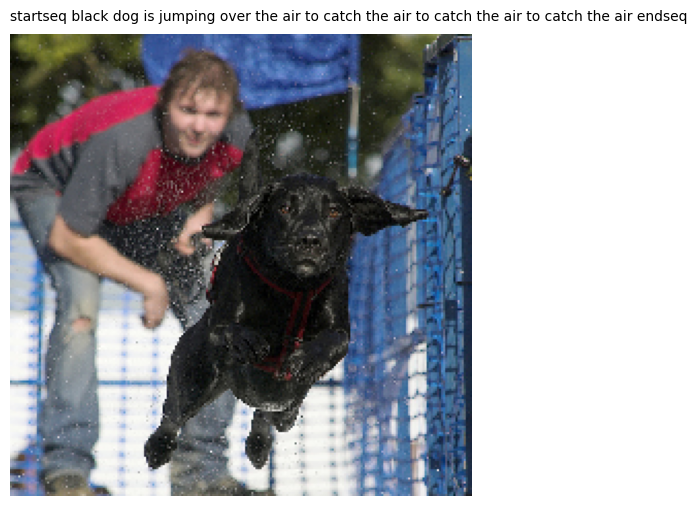

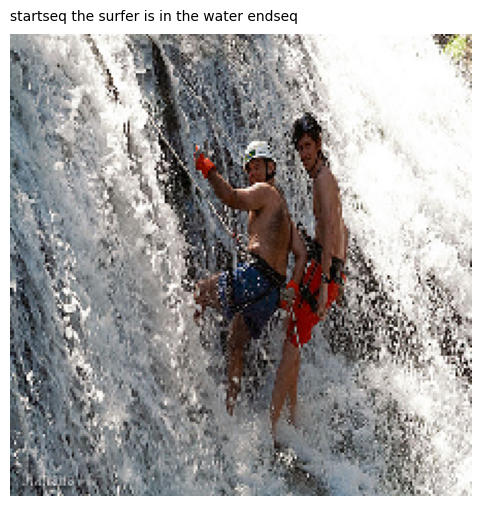

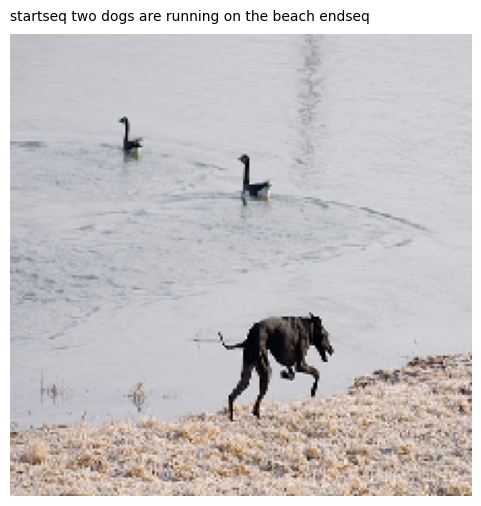

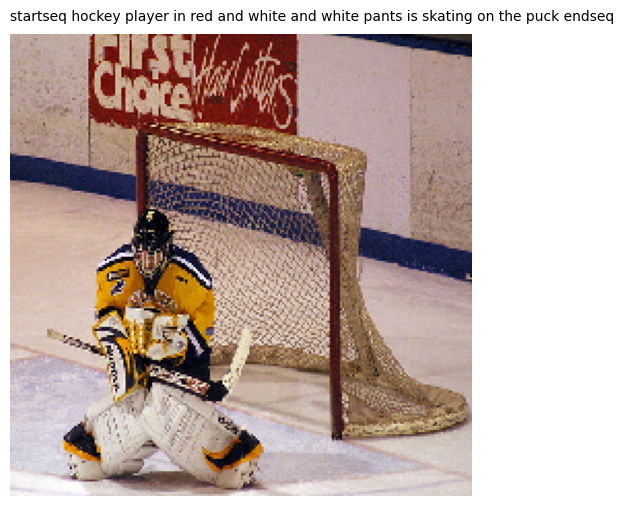

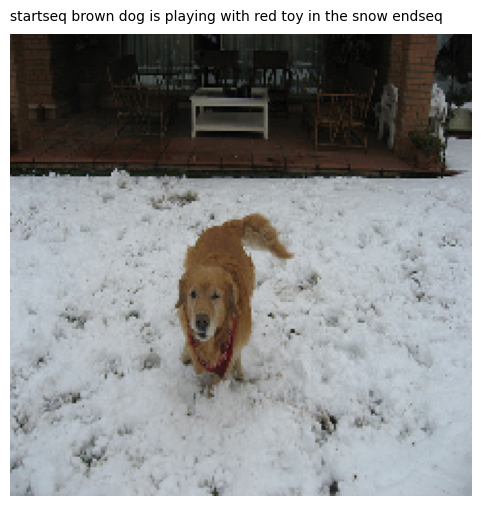

In [ ]:
import random
samples = random.sample(img_test, 5)

for img in samples:
  cap = predict_caption(model, tokenizer, max_length, feature_dict[img])
  previewImageCaption(img, [cap])

# Save model, tokenizer

KeyError: 'accuracy'

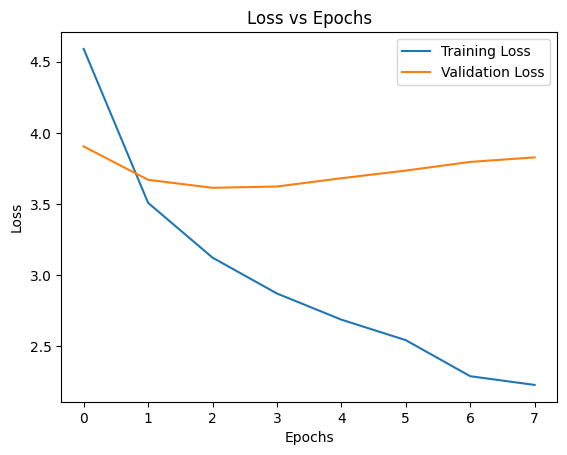

In [ ]:
# Vẽ đồ thị Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Vẽ đồ thị Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---
# Temp (Section này dùng để nháp)


In [ ]:
model = tf.keras.models.load_model('/content/model.keras')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,244,864 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8769)      │  2,253,633 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,415,301 (70.25 MB)

 Trainable params: 6,138,433 (23.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,276,868 (46.83 MB)

In [ ]:
data_generator = DataGenerator(features_train_repeated, sequences_train, tokenizer, 30)
history = model.fit(data_generator, epochs=1)


1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1514s 1s/step - accuracy: 0.7337 - loss: 0.9833


In [ ]:
# Vẽ đồ thị Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Vẽ đồ thị Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Lấy batch đầu tiên
(X1, X2), y = train_generator[0]
i = 11

print("X1 (image features):", X1.shape)
print("X2 (input sequence):", X2.shape)
print("y (target word index):", y.shape)
print("Example input sequence:", X2[i])
print("Target word index:", y[i])

X1 (image features): (639, 4096)
X2 (input sequence): (639, 34)
y (target word index): (639,)
Example input sequence: [   2  183   26   98    4 1703    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
Target word index: 350


In [ ]:
X_train.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going into a wooden building .   
2   A little girl climbing into a wooden playhouse .   
3  A little girl climbing the stairs to her playh...   
4  A little girl in a pink dress going into a woo...   

                                             sequece  \
0  startseq child in pink dress is climbing up se...   
1    startseq girl going into wooden building endseq   
2  startseq little girl climbing into wooden play...   
3  startseq little girl climbing the stairs to he...   
4  startseq little girl in pink dress going into ...   

                                            sequence  
0  startseq child in pink dress is climbing up se...  
1    startseq girl going into wooden building endseq  
2  startseq little girl climbing into wooden play...  
3  startseq little girl climbing the stairs to he...  
4  startseq little girl in pink dress going into ...

# Cách chạy model đã train

## Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load model và feature ảnh

In [ ]:
from tensorflow.keras.models import load_model
DRIVE_PATH = '/content/drive/MyDrive/SHARE/ImageCaptioning'
model = load_model(DRIVE_PATH + "/models/model_3/model.keras")
features = np.load(DRIVE_PATH + "/features.npy")

## Tạo feature dictionary

In [ ]:
images = df['image'].unique().tolist()

feature_dict = {}

for image, feature in zip(images, features):
  feature_dict[image] = feature

print(features.shape)
print(len(feature_dict))

(8091, 4096)
8091


## Tạo tokenizer

In [ ]:
# Tokenization
def tokenization(captions, num_words=10000):
  # giới hạn độ dài tối đa của mỗi câu
  max_length = max(len(cap.split()) for cap in captions)

  # tạo tokenizer
  tokenizer = Tokenizer(num_words=num_words, oov_token='<unk>')
  tokenizer.fit_on_texts(captions)

  # report
  print('max_length:', max_length)
  print('vocab_size:', len(tokenizer.word_index)+1)
  print("word_index:", tokenizer.word_index)
  print("word_counts:", tokenizer.word_counts)

  return tokenizer, max_length

###
tokenizer, max_length = tokenization(captions)

max_length: 34
vocab_size: 8769
word_index: {'<unk>': 1, 'startseq': 2, 'endseq': 3, 'in': 4, 'the': 5, 'on': 6, 'is': 7, 'and': 8, 'dog': 9, 'with': 10, 'man': 11, 'of': 12, 'two': 13, 'white': 14, 'black': 15, 'boy': 16, 'are': 17, 'woman': 18, 'girl': 19, 'to': 20, 'wearing': 21, 'at': 22, 'people': 23, 'water': 24, 'red': 25, 'young': 26, 'brown': 27, 'an': 28, 'his': 29, 'blue': 30, 'dogs': 31, 'running': 32, 'through': 33, 'playing': 34, 'while': 35, 'down': 36, 'shirt': 37, 'standing': 38, 'ball': 39, 'little': 40, 'grass': 41, 'child': 42, 'person': 43, 'snow': 44, 'jumping': 45, 'over': 46, 'front': 47, 'three': 48, 'sitting': 49, 'holding': 50, 'field': 51, 'small': 52, 'up': 53, 'by': 54, 'large': 55, 'green': 56, 'group': 57, 'one': 58, 'yellow': 59, 'her': 60, 'walking': 61, 'children': 62, 'men': 63, 'into': 64, 'air': 65, 'beach': 66, 'near': 67, 'mouth': 68, 'jumps': 69, 'another': 70, 'for': 71, 'street': 72, 'runs': 73, 'its': 74, 'from': 75, 'riding': 76, 'stands': 7

## Predict and evaluate

1. Hàm tạo caption từ ảnh

In [ ]:
def predict_caption(model, tokenizer, max_length, feature_vector):
    # Bắt đầu với từ 'startseq' để tạo caption
    in_text = 'startseq'

    # Tiến hành dự đoán từng từ cho đến khi gặp 'endseq'
    for _ in range(max_length):
        # Chuyển chuỗi input thành một danh sách các token
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # Padding để đảm bảo chuỗi có độ dài max_length
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Dự đoán từ tiếp theo
        yhat = model.predict([np.expand_dims(feature_vector, axis=0), sequence], verbose=0)

        # Chuyển output từ mô hình (xác suất) thành chỉ số của từ có xác suất cao nhất
        yhat = np.argmax(yhat)

        # Chuyển chỉ số của từ thành từ tương ứng trong từ điển
        word = tokenizer.index_word.get(yhat, '')

        in_text += ' ' + word

        # Nếu gặp token kết thúc endseq thì đừng
        if word == 'endseq': break

    return in_text


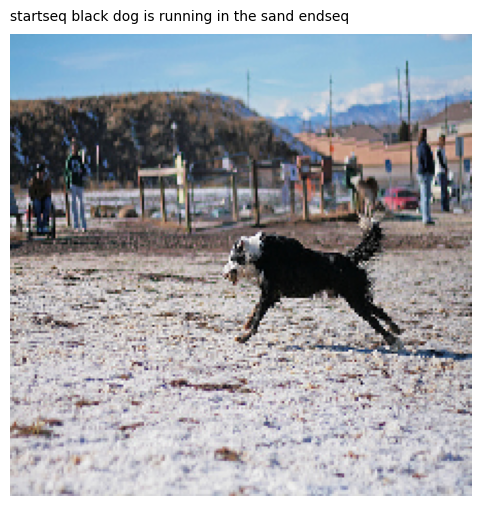

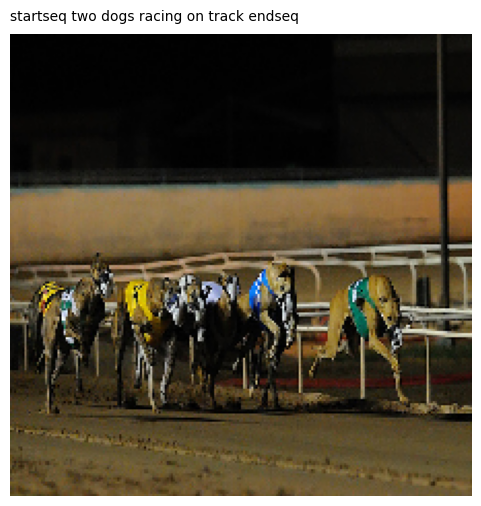

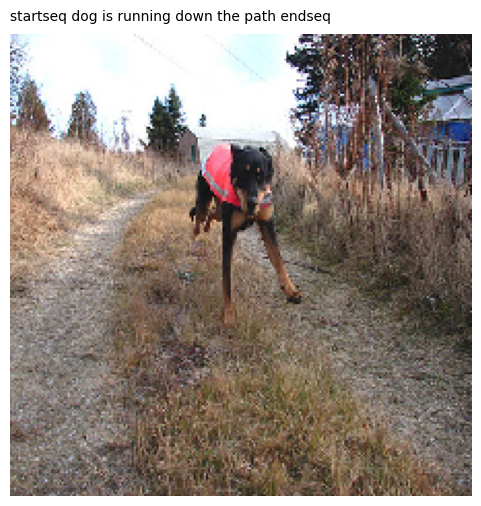

In [ ]:
import random
samples = random.sample(images, 3)

for img in samples:
  cap = predict_caption(model, tokenizer, max_length, feature_dict[img])
  previewImageCaption(img, [cap])

Đi đến bước 5 nếu đã có actual_predicted.pkl

2. Tạo references từ file Flickr8k.token.txt

In [ ]:
references = {}
with open(DRIVE_PATH + '/Flickr8k.token.txt', 'r') as f:
    for line in f:
        image_id, caption = line.strip().split('\t')
        image_id = image_id.split('#')[0]
        if image_id not in references:
            references[image_id] = []
        references[image_id].append(caption.lower())


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ML/Image Captioning/Flickr8k.token.txt'

3. Tạo actual và predicted

In [ ]:
actual, predicted = [], []

for image_id in images:
    y_pred = predict_caption(model, tokenizer, max_length, feature_dict[image_id])
    y_pred = y_pred.replace('startseq', '').replace('endseq', '').strip().split()

    # Tokenize các caption đúng (ground truth)
    ref_caps = [ref.split() for ref in references[image_id]]

    actual.append(ref_caps)
    predicted.append(y_pred)


4. Lưu actual và predicted vào drive

In [ ]:
import pickle

path = DRIVE_PATH + '/actual_predicted.pkl'
with open(path, 'wb') as f:
    pickle.dump({'actual': actual, 'predicted': predicted}, f)


5. Load lại actual và predicted

In [ ]:
with open(DRIVE_PATH + '/actual_predicted.pkl', 'rb') as f:
    data = pickle.load(f)
    actual = data['actual']
    predicted = data['predicted']


6. Tính BLEU, METEOR và CIDEr

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Cần cho các phiên bản NLTK mới


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

# BLEU
bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

# METEOR (tính trung bình)
meteor_total = 0
for i in range(len(actual)):
    ref_sentences = actual[i]
    pred_sentence = predicted[i]
    meteor_total += meteor_score(ref_sentences, pred_sentence)
meteor_avg = meteor_total / len(actual)

print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-4: {bleu4:.4f}")
print(f"METEOR: {meteor_avg:.4f}")


BLEU-1: 0.5296
BLEU-4: 0.1287
METEOR: 0.2985


In [ ]:
# Tính CIDEr
# Để tính CIDEr, cần thư viện pycocoevalcap, nhưng nó không có trên PyPI
# Clone repo COCO caption evaluation
!git clone https://github.com/tylin/coco-caption
!pip install pycocoevalcap

Cloning into 'coco-caption'...
remote: Enumerating objects: 736, done.
remote: Total 736 (delta 0), reused 0 (delta 0), pack-reused 736 (from 1)
Receiving objects: 100% (736/736), 130.04 MiB | 15.69 MiB/s, done.
Resolving deltas: 100% (390/390), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.8 MB/s eta 0:00:00


In [ ]:
from pycocoevalcap.cider.cider import Cider

# Convert data to format expected by pycocoevalcap
gts = {i: [' '.join(ref) for ref in actual[i]] for i in range(len(actual))}
res = {i: [' '.join(predicted[i])] for i in range(len(predicted))}

cider_scorer = Cider()
score, _ = cider_scorer.compute_score(gts, res)

print(f"CIDEr: {score:.4f}")


CIDEr: 0.4735


## Tính BLEU Score theo sentence

Dự đoán ngẫu nghiêm 1 ảnh nào đó

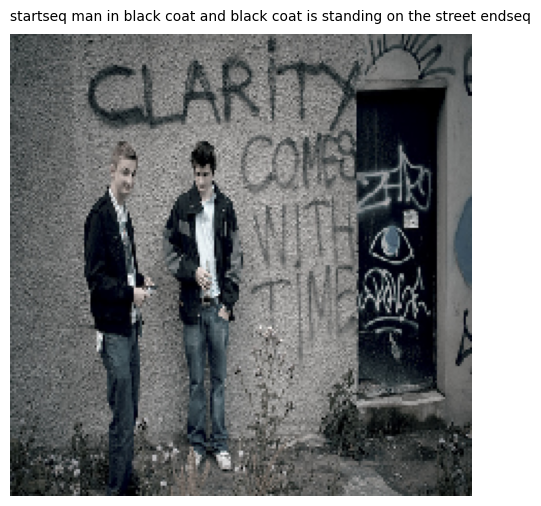

In [ ]:
img = random.sample(images, 1)[0]

pred = predict_caption(model, tokenizer, max_length, feature_dict[img])
previewImageCaption(img, [pred])

Lấy token hypothesis và references

In [ ]:
# Cái này là hypothesis để đưa vào tính bleu
hypo = pred.replace('startseq', '').replace('endseq', '').strip().split()

In [ ]:
# Cái này để lấy ra 5 captions tương ứng của image để đưa vào references tính bleu
def get_actual_captions(img):
  actual = df[df['image']==img]['caption'].to_list()
  refs = []
  for cap in actual:
    refs.append(cap.split())
  return refs

In [ ]:
# Preview hypo và refs
print("hypothesis: ")
print(hypo)

print("references: ")
refs = get_actual_captions(img)
for ref in refs: print(ref)

hypothesis: 
['man', 'in', 'black', 'coat', 'and', 'black', 'coat', 'is', 'standing', 'on', 'the', 'street']
references: 
['Two', 'guys', 'stand', 'outside', 'of', 'a', 'building', 'that', 'has', 'been', 'spray', 'painted', 'with', 'words', '.']
['Two', 'men', 'stand', 'near', 'a', 'wall', 'that', 'has', 'writing', 'painted', 'on', 'it', '.']
['Two', 'young', 'men', 'drink', 'beer', ',', 'leaning', 'on', 'a', 'graffitied', 'wall', '.']
['Two', 'young', 'men', 'in', 'black', 'jackets', 'hanging', 'out', 'by', 'a', 'graffitied', 'wall']
['Two', 'young', 'men', 'in', 'jeans', 'and', 'dark', 'jackets', 'standing', 'in', 'front', 'of', 'a', 'building', '.']


Tính BLEU-1 score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# Tính điểm BLEU-1
weights = (1, 0, 0, 0) # bleu-1
score = sentence_bleu(refs, hypo, weights=weights)
print(f"BLEU-1: {score}")

BLEU-1: 0.4166666666666667


Thống kê các token theo unigram (bleu-1)

In [ ]:
from collections import Counter

def bleu1_stats_dict(hypo, refs):
  hypo_counts = Counter(hypo)

  max_ref_counts = Counter()
  for ref in refs:
      ref_counts = Counter(ref)
      for word in hypo_counts:
          # Cập nhật nếu thấy 1 giá trị khác cao hơn
          max_ref_counts[word] = max(max_ref_counts[word], ref_counts[word])

  clipped_counts = {word: min(hypo_counts[word], max_ref_counts[word]) for word in hypo_counts}

  precision = sum(clipped_counts.values()) / max(1, sum(hypo_counts.values()))

  total_hypo = sum(hypo_counts.values())
  total_max_ref = sum(max_ref_counts[word] for word in hypo_counts)
  total_clipped = sum(clipped_counts.values())

  result = {
      "hypo_counts": dict(hypo_counts),
      "max_ref_counts": dict(max_ref_counts),
      "clipped_counts": clipped_counts,
      "totals": {
          "hypo_counts": total_hypo,
          "max_ref_counts": total_max_ref,
          "clipped_counts": total_clipped,
      },
      "bleu_1": precision,
  }

  return result

In [ ]:
stats = bleu1_stats_dict(hypo, refs)
for key, value in stats.items():
  print(f"{key}: {value}")

hypo_counts: {'man': 1, 'in': 1, 'black': 2, 'coat': 2, 'and': 1, 'is': 1, 'standing': 1, 'on': 1, 'the': 1, 'street': 1}
max_ref_counts: {'man': 0, 'in': 2, 'black': 1, 'coat': 0, 'and': 1, 'is': 0, 'standing': 1, 'on': 1, 'the': 0, 'street': 0}
clipped_counts: {'man': 0, 'in': 1, 'black': 1, 'coat': 0, 'and': 1, 'is': 0, 'standing': 1, 'on': 1, 'the': 0, 'street': 0}
totals: {'hypo_counts': 12, 'max_ref_counts': 6, 'clipped_counts': 5}
bleu_1: 0.4166666666666667


In [ ]:
from prettytable import PrettyTable

hypo_counts = stats['hypo_counts']
max_ref_counts = stats['max_ref_counts']
clipped_counts = stats['clipped_counts']
total_hypo = stats['totals']['hypo_counts']
total_max_ref = stats['totals']['max_ref_counts']
total_clipped = stats['totals']['clipped_counts']
bleu_1 = 0.4166666666666667

tokens = list(hypo_counts.keys())

table = PrettyTable()
table.field_names = ["Metric"] + tokens

table.add_row(["hypo_counts"] + [hypo_counts.get(t, 0) for t in tokens])
table.add_row(["max_ref_counts"] + [max_ref_counts.get(t, 0) for t in tokens])
table.add_row(["clipped_counts"] + [clipped_counts.get(t, 0) for t in tokens])

print(table)
print(f"\ntotal_hypo: {total_hypo}")
print(f"total_max_ref: {total_max_ref}")
print(f"total_clipped: {total_clipped}")
print(f"\nBLEU-1: {total_clipped}/{total_hypo} = {bleu_1:.4f}")


+----------------+-----+----+-------+------+-----+----+----------+----+-----+--------+
|     Metric     | man | in | black | coat | and | is | standing | on | the | street |
+----------------+-----+----+-------+------+-----+----+----------+----+-----+--------+
|  hypo_counts   |  1  | 1  |   2   |  2   |  1  | 1  |    1     | 1  |  1  |   1    |
| max_ref_counts |  0  | 2  |   1   |  0   |  1  | 0  |    1     | 1  |  0  |   0    |
| clipped_counts |  0  | 1  |   1   |  0   |  1  | 0  |    1     | 1  |  0  |   0    |
+----------------+-----+----+-------+------+-----+----+----------+----+-----+--------+

total_hypo: 12
total_max_ref: 6
total_clipped: 5

BLEU-1: 5/12 = 0.4167


---
# NGUỒN THAM KHẢO
[1] Google, Show and tell paper, arxiv.org. Available: https://arxiv.org/pdf/1411.4555

[2] Quadeer Shaikh, Flickr8K Image Captioning using CNNs+LSTMs, Kaggle. Available: https://www.kaggle.com/code/quadeer15sh/flickr8k-image-captioning-using-cnns-lstms/notebook

[3] Hackers Realm, Image Caption Generator using Flickr Dataset, Youtube. Available: https://www.youtube.com/watch?v=fUSTbGrL1tc

[4] DeepLearningAI, Bleu Score C5W3L06, Youtube.  Available: https://www.youtube.com/watch?v=DejHQYAGb7Q&t=529s

[5] NGHIÊN CỨU CÁC PHƯƠNG PHÁP VÀ ĐỀ XUẤT HỆ THỐNG ĐÁNH GIÁ
CHẤT LƯỢNG DỊCH TỰ ĐỘNG SONG NGỮ ANH – VIỆT. Available: https://elib.vku.udn.vn/bitstream/123456789/77/1/full.pdf


# LIVE DEMO: https://huggingface.co/spaces/bqtankiet/image-captioning-demo